In [1]:
!pip install numpy imageio matplotlib

In [1]:
from ipfspy.ipfsspec import asyn

from ipfspy.ipfshttpapi import IPFSApi

api =  IPFSApi()
api.change_gateway_type = 'local'

Changed to local node
Changed to local node


In [6]:
import os
from tqdm import tqdm
import pandas as pd
class DownloadDir:
    'Download a IPFS directory to your local disk'
    def __init__(self,
        gateway_type:str, # Gateway to use - works on local and public 
        root_cid:str, # Root CID of the directory
        output_folder:str, # Path to save in your local disk
    ):
        
        self.api = IPFSApi(gateway_type=gateway_type)
        self.root = root_cid
        self.output = output_folder
        self.full_structure = None
    
    def _get_links(self,
        cid, 
        fol
    ):
        root_struct = {}
        struct = {}
        _, obj = self.api.ls_items(cid)
        
        links = obj[0]['Objects'][0]['Links']
    
        
        for link in links:
            name = f'{fol}/{link["Name"]}'
            hash_ = str(link['Hash'])
            type_ = link['Type']

            if type_ != 2:
                details = self._get_links(hash_, name)
                

            else:
                details = {'Hash': hash_,'type': type_}

            struct[name] = details

        root_struct[fol] = struct

        return root_struct
    
    
    def _save_links(self,
        links
    ): 
                
        if isinstance(links,dict):
            for k, v in links.items():
                if "Hash" in links[k]:
                    res, data = self.api.cat_items(links[k]['Hash'])
                    with open(k, 'wb') as f:
                        f.write(res.content)

                else: 
                    if not os.path.exists(k): os.mkdir(k)
                    self._save_links(v)


    
    def download(self
    ):
        
        self.full_structure = self._get_links(self.root, self.output)
        
        self._save_links(self.full_structure)
        return pd.DataFrame(self.full_structure)

# Activeloop load dataset and use inherit sampling

In [81]:
import hub
def flow(path,ingest_path,d_path,cid=None):
    
    if not cid:

        hub.ingest(path,ingest_path,overwrite=True,progressbar=False)   

        _, data = api.add_items(ingest_path, directory=True,wrap_with_directory=True)

        cid = data[-2]["Hash"]#-2 is to get the bottom 2nd top folder therefore the download before doesn't nest the ingest path
    
    download = DownloadDir('local', cid, d_path)
    
    b =download.download()
    
    ds = hub.load(d_path)
    
    return ds

In [88]:
import matplotlib.pyplot as plt
import numpy as np
def image(ds,index):

    image = ds[index].numpy()


    plt.imshow(image)
    plt.show()

In [83]:
w = flow("./mnist","./mnist-test3","./mnist_quick")



Ingestion Complete. No files were skipped.


Changed to local node
./mnist_quick loaded successfully.


In [92]:
w["train/images"].shape

(60000, 28, 28)

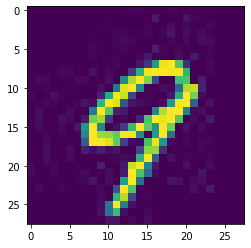

In [90]:
image(w["train/images"],0)


# Music

In [66]:
w = flow("./class","./stems","./FinalStems")

Ingesting "class" (0 files skipped): 100%|██████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  5.01it/s]




Ingestion Complete. No files were skipped.


Changed to local node
./FinalStems loaded successfully.


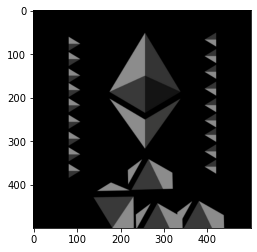

In [67]:
image(w,5)

# IPFS only Sample

In [ ]:
import numpy as np

state = np.random.RandomState(42)

random_sample = state.choice(sample,size=1,replace=True)

In [ ]:
random_sample.shape

In [ ]:
import imageio

import matplotlib.pyplot as plt


img = imageio.imread(sample[0])
plt.imshow(img)
plt.show()

In [ ]:
get_dag("Qmcy5fmrYFKJsyriJQvrQrQGaMaxjLEYmAN7KNShnSjTbQ")

In [ ]:
import requests

#recursive
def get_cid(cid):
    
    response = api.cat_items(cid)
    
    return response


def get_dag(cid):
    
    response = api.dag_get(cid)
    
    cid_dict = [cid["Hash"] for cid in response.json()["links"]]
    
    cids_list = [cid["/"] for cid in cid_dict]
    
    return cids_list


def get_sample(cids:list,size=2):
               
    files = []    
    
    if not isinstance(cids,list):
        raise TypeError("cids must be a list")
                
    for cid in cids:

        if len(files) < size:
            response = get_cid(cid)

            if response.status_code == 200:

                files.append(response.content)

            else:
                dag = get_dag(cid)
                cids +=dag #adds the list cids from dag to cids

        else:
            break

    return files

        
        

In [4]:
#QmU7Q4YugrhqcjChpLaEZNiK7E98ih6Zp3kPuTFst3agLM is the cid of M

sample = get_sample(["Hash"],size=100)

len(sample)

HTTPError: Response Status Code: 500; Error Message: invalid path "Hash": selected encoding not supported

In [5]:
import requests

#recursive
def get_cid(cid):
    
    responses = []
    
    params = {
        'arg': cid,
        'progress': 'true',
    }

    response = requests.post('http://127.0.0.1:5001/api/v0/cat', params=params)
    
    return response


def get_dag(cid):
    
    params = {
        'arg': cid,
        'output-codec': 'dag-json',
    }

    response = requests.post('http://127.0.0.1:5001/api/v0/dag/get', params=params)
    
    cid_list = [c["Hash"]["/"] for c in response.json()["Links"]]
    
    return cid_list


def get_sample(cids:list,size=2):
               
    files = []
    
    
    if not isinstance(cids,list):
        raise TypeError("cids must be a list")
                
    for cid in cids:

        if len(files) < size:
            response = get_cid(cid)

            if response.status_code == 200:

                files.append(response.content)

            else:
                dag = get_dag(cid)
                cids +=dag #adds the list cids from dag to cids

        else:
            break

    return files

        
        